In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
from datetime import datetime

OUTPUT_DIR = Path("../output").resolve()
FIGURES_DIR = OUTPUT_DIR / "figures"
CONSOMMATIONS_ENRICHIES_PARQUET_PATH = OUTPUT_DIR / "consommations_enrichies"
CONSOMMATIONS_ENRICHIES_CSV_PATH = OUTPUT_DIR / "consommations_enrichies.csv"

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [3]:
df = pd.read_parquet(CONSOMMATIONS_ENRICHIES_PARQUET_PATH.as_posix())
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = pd.to_datetime(df['date'])
df['date_debut'] = pd.to_datetime(df['date_debut'])
df['date_fin'] = pd.to_datetime(df['date_fin'])
df['type_energie'] = df['type_energie'].astype("str")

print(f"Donnees chargees: {len(df):,} lignes")
print(f"Periode: {df['date'].min()} -> {df['date'].max()}")

Donnees chargees: 7,492,584 lignes
Periode: 2023-01-01 00:00:00 -> 2024-12-31 00:00:00


#### Etape 4.3 : Dashboard executif
Creer un dashboard multi-panneaux (2x3) synthetisant les resultats :

- Panel 1 : Evolution de la consommation totale (6 derniers mois)
- Panel 2 : Top 10 batiments les plus energivores (bar horizontal)
- Panel 3 : Repartition des couts par type d'energie (pie chart)
- Panel 4 : Consommation moyenne par classe DPE avec ecart-type
- Panel 5 : Carte de chaleur par commune
- Panel 6 : Economies potentielles par amelioration du DPE

**Livrables** :
- Notebook `11_dashboard_executif.ipynb`
- Figure dashboard `output/figures/dashboard_energie.png`

In [4]:
# Preparer les donnees pour chaque panel
# On sélectionne les 6 derniers mois
date_debut_etude = datetime.strptime("2024-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")
df_electricite = df[(df["type_energie"] == "electricite") & (df["timestamp"] >= date_debut_etude)].copy()

# Panel 1: Evolution temporelle consommation électrique
daily_electricite = df_electricite.groupby("date")["consommation"].mean()

# Panel 2: Top 10 bâtiments les plus energivores
top10_batiments = df_electricite.groupby("type")["consommation"].mean().nlargest(5)

# Panel 3: Répartition des coût par type d'énergie
cout_type_energie = df[df["timestamp"] >= date_debut_etude].groupby("type_energie")["cout_mensuel"].sum()

# Panel 4: Consommation moyenne par DPE
dpe = df_electricite.groupby("classe_energetique")["consommation"].mean()

# Panel 5: Carte de chaleur par commune
# Pivot: jour de commune x type bâtiment
pivot_heatmap = df_electricite.pivot_table(
    values="consommation",
    index='commune',
    columns='type',
    aggfunc='mean'
)
type_batiment = ['ecole', 'mairie', 'mediatheque', 'gymnase', 'piscine']
commune = [
    'Nantes',
    'Paris',
    'Lyon',
    'Strasbourg',
    'Montpellier',
    'Marseille',
    'Nice',
    'Toulouse',
    'Bordeaux',
    'Rennes',
    'Lille',
    'Reims',
    'Le Havre',
    'Saint-Etienne',
    'Toulon',
]
commune = sorted(commune)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Administrateur\AppData\Local\Temp\ipykernel_24656\1981506040.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


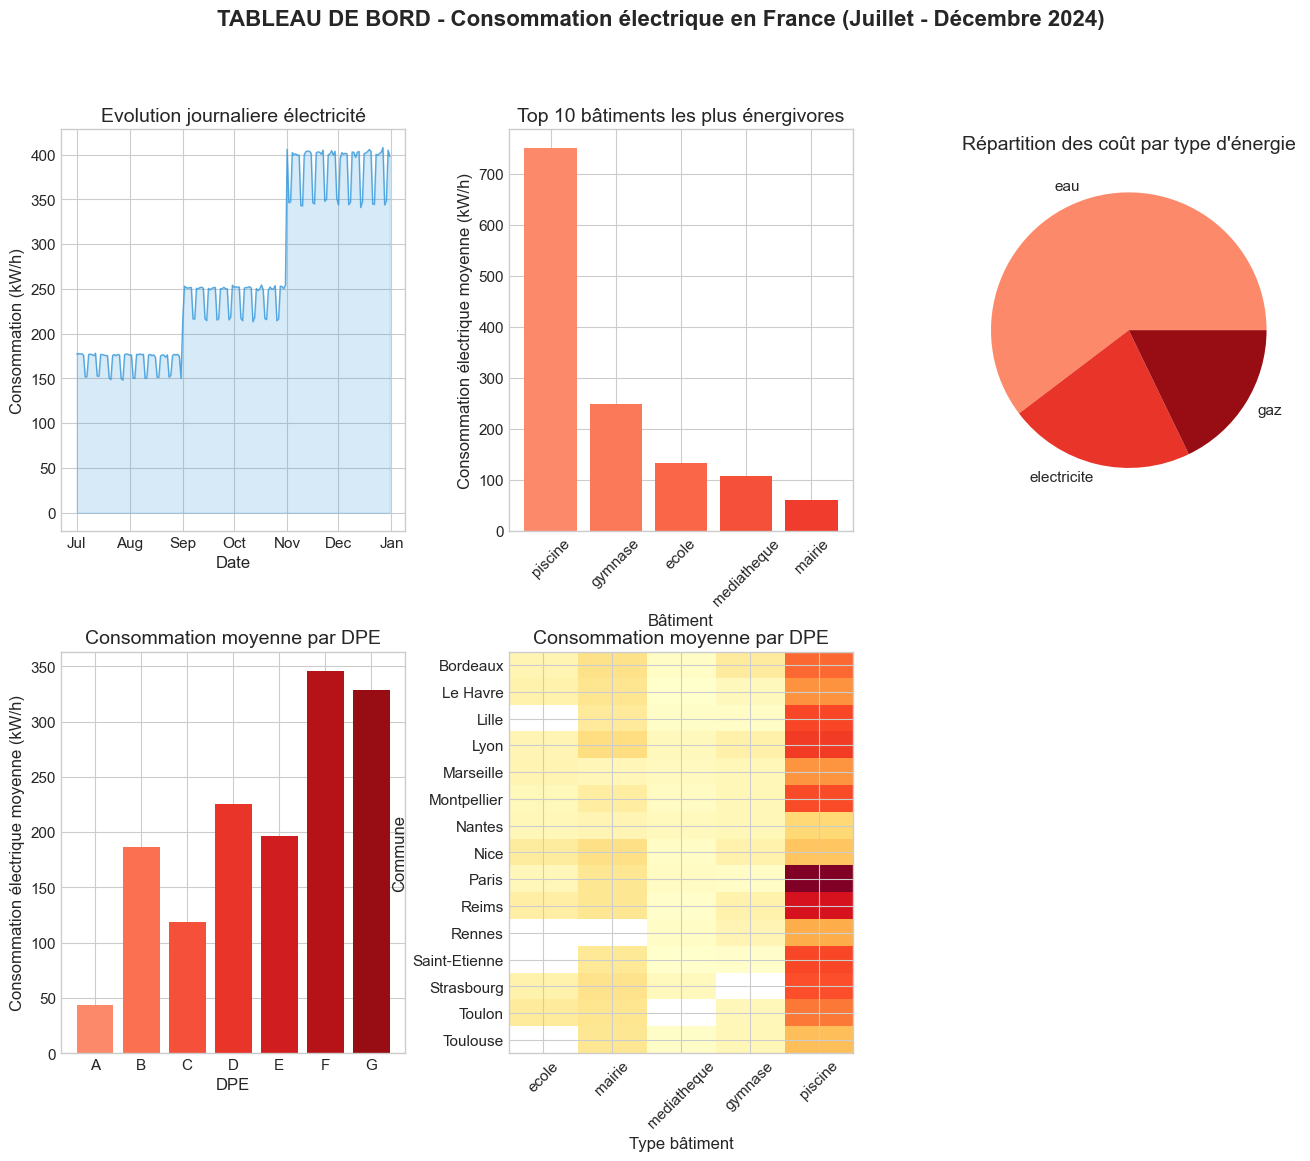

In [5]:
# Creer le dashboard
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

# Couleurs
colors = {
    "primary": "#3498DB",
    "secondary": "#E74C3C",
    "accent": "#2ECC71",
    "warning": "#F39C12",
    "danger": "#E74C3C"
}

# ===================
# Panel 1: Evolution temporelle PM2.5 avec seuils
# ===================
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(daily_electricite.index, daily_electricite.values, color=colors["primary"], linewidth=1, alpha=0.8)
ax1.fill_between(daily_electricite.index, daily_electricite.values, alpha=0.2, color=colors["primary"])
ax1.set_title("Evolution journaliere électricité")
ax1.set_xlabel("Date")
ax1.set_ylabel("Consommation (kW/h)")
ax1.legend(loc="upper right", fontsize=8)
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))

# ===================
# Panel 2: Top 10 bâtiments les plus énergivores
# ===================
ax2 = fig.add_subplot(gs[0, 1])
colors_top10 = plt.cm.Reds(np.linspace(0.4, 0.9, 10))
ax2.bar(top10_batiments.index, top10_batiments.values, color=colors_top10)
ax2.set_title("Top 10 bâtiments les plus énergivores")
ax2.set_xlabel("Bâtiment")
ax2.set_ylabel("Consommation électrique moyenne (kW/h)")
ax2.tick_params(axis="x", rotation=45)

# ===================
# Panel 3: Répartition des coût par type d'énergie
# ===================
ax3 = fig.add_subplot(gs[0, 2])
colors_pie = plt.cm.Reds(np.linspace(0.4, 0.9, 3))
ax3.pie(labels=cout_type_energie.index, x=cout_type_energie.values, colors=colors_pie)
ax3.set_title("Répartition des coût par type d'énergie")

# ===================
# Panel 4: Consommation moyenne par DPE
# ===================
ax4 = fig.add_subplot(gs[1, 0])
colors_top10 = plt.cm.Reds(np.linspace(0.4, 0.9, 7))
ax4.bar(dpe.index, dpe.values, color=colors_top10)
ax4.set_title("Consommation moyenne par DPE")
ax4.set_xlabel("DPE")
ax4.set_ylabel("Consommation électrique moyenne (kW/h)")

# ===================
# Panel 5: Carte d chaleur par commune
# ===================
ax5 = fig.add_subplot(gs[1, 1])
ax5.imshow(pivot_heatmap.values, cmap='YlOrRd', aspect='auto')
ax5.set_title("Consommation moyenne par DPE")
ax5.set_xlabel("Type bâtiment")
ax5.set_ylabel("Commune")
ax5.set_xticks(range(5))
ax5.set_xticklabels(type_batiment)
ax5.set_yticks(range(len(commune)))
ax5.set_yticklabels(commune)
ax5.tick_params(axis="x", rotation=45)

# Titre global
fig.suptitle("TABLEAU DE BORD - Consommation électrique en France (Juillet - Décembre 2024)", 
             fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURES_DIR}/dashboard_consommation_energetique.png", dpi=300, bbox_inches="tight", 
            facecolor="white", edgecolor="none")
plt.show()